# Utilities
----------------

This example shows various useful utilities that can be used to improve atom's pipelines.

The data used is a variation on the [Australian weather dataset](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) from Kaggle. You can download it from [here](https://github.com/tvdboom/ATOM/blob/master/examples/datasets/weatherAUS.csv). The goal of this dataset is to predict whether or not it will rain tomorrow training a binary classifier on target `RainTomorrow`.

## Load the data

In [85]:
# Import packages
import pandas as pd
from sklearn.metrics import fbeta_score
from atom import ATOMClassifier, ATOMLoader

In [86]:
# Load data
X = pd.read_csv("./datasets/weatherAUS.csv")

# Let's have a look
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,MelbourneAirport,18.0,26.9,21.4,7.0,8.9,SSE,41.0,W,SSE,...,95.0,54.0,1019.5,1017.0,8.0,5.0,18.5,26.0,Yes,0
1,Adelaide,17.2,23.4,0.0,NaN,NaN,S,41.0,S,WSW,...,59.0,36.0,1015.7,1015.7,NaN,NaN,17.7,21.9,No,0
2,Cairns,18.6,24.6,7.4,3.0,6.1,SSE,54.0,SSE,SE,...,78.0,57.0,1018.7,1016.6,3.0,3.0,20.8,24.1,Yes,0
3,Portland,13.6,16.8,4.2,1.2,0.0,ESE,39.0,ESE,ESE,...,76.0,74.0,1021.4,1020.5,7.0,8.0,15.6,16.0,Yes,1
4,Walpole,16.4,19.9,0.0,NaN,NaN,SE,44.0,SE,SE,...,78.0,70.0,1019.4,1018.9,NaN,NaN,17.4,18.1,No,0


## Use the utility attributes

In [87]:
atom = ATOMClassifier(X, warnings=False, random_state=1)
atom.clean()

# Quickly check what columns have missing values
print(f"Columns with missing values:\n{atom.nans}")

# Or what columns are categorical
print(f"\nCategorical columns: {atom.categorical}")

# Or if the dataset is scaled
print(f"\nIs the dataset scaled? {atom.scaled}")

Columns with missing values:
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
dtype: int64

Categorical columns: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

Is the dataset scaled? False


## Use the stats method to assess changes in the dataset

In [88]:
# Note the number of missing values and categorical columns
atom.stats()

Dataset stats ====================== >>
Shape: (142193, 22)
Scaled: False
Missing values: 316559 (10.1%)
Categorical features: 5 (23.8%)
Duplicate samples: 45 (0.0%)
---------------------------------------
Train set size: 113755
Test set size: 28438
---------------------------------------
|    | dataset      | train       | test        |
|---:|:-------------|:------------|:------------|
|  0 | 110316 (3.5) | 88412 (3.5) | 21904 (3.4) |
|  1 | 31877 (1.0)  | 25343 (1.0) | 6534 (1.0)  |


In [89]:
# Now, let's impute and encode the dataset...
atom.impute()
atom.encode()

# ... and the values are gone
atom.stats()

Dataset stats ====================== >>
Shape: (56420, 22)
Scaled: False
Outlier values: 3220 (0.3%)
---------------------------------------
Train set size: 45150
Test set size: 11270
---------------------------------------
|    | dataset     | train       | test       |
|---:|:------------|:------------|:-----------|
|  0 | 43993 (3.5) | 35276 (3.6) | 8717 (3.4) |
|  1 | 12427 (1.0) | 9874 (1.0)  | 2553 (1.0) |


## Inspect feature distributions

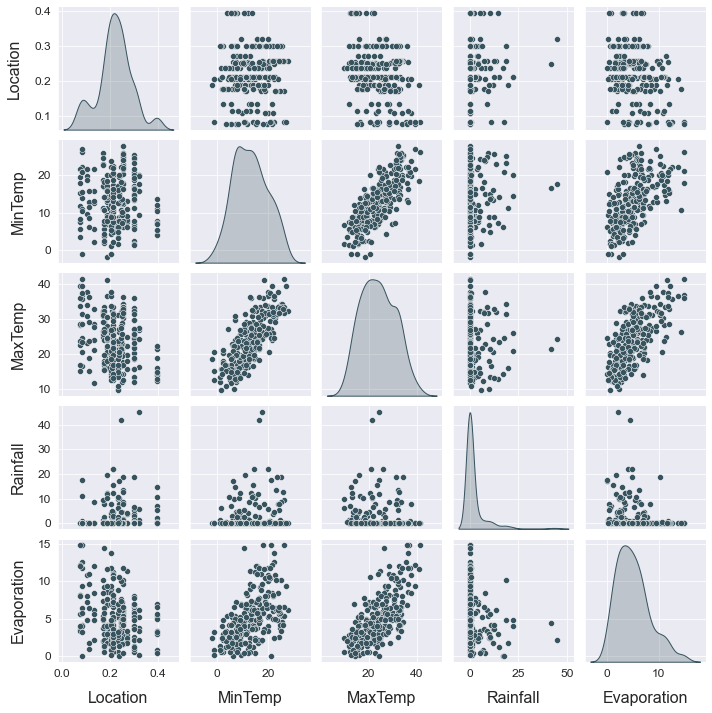

In [90]:
# Compare the relationship of multiple columns with a scatter maxtrix
atom.plot_scatter_matrix(columns=slice(0, 5))

In [91]:
# Check which distribution fits a column best
atom.distribution("MinTemp")

,ks,p_value
beta,0.0296,0.0
weibull_min,0.0331,0.0
weibull_max,0.0341,0.0
lognorm,0.0344,0.0
gamma,0.0345,0.0
pearson3,0.0345,0.0
norm,0.0369,0.0
invgauss,0.0445,0.0
triang,0.0814,0.0
uniform,0.2175,0.0


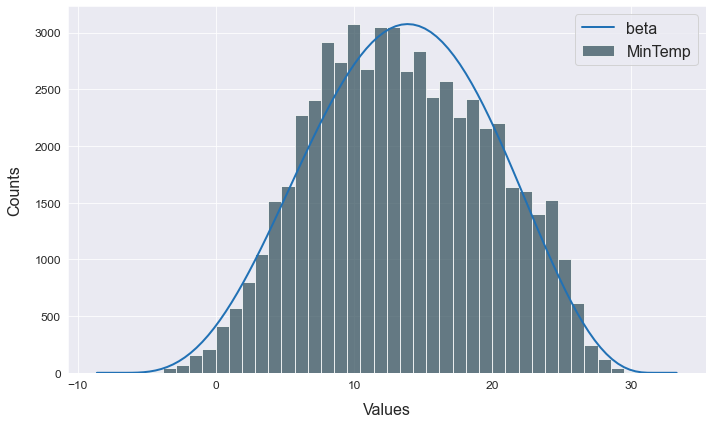

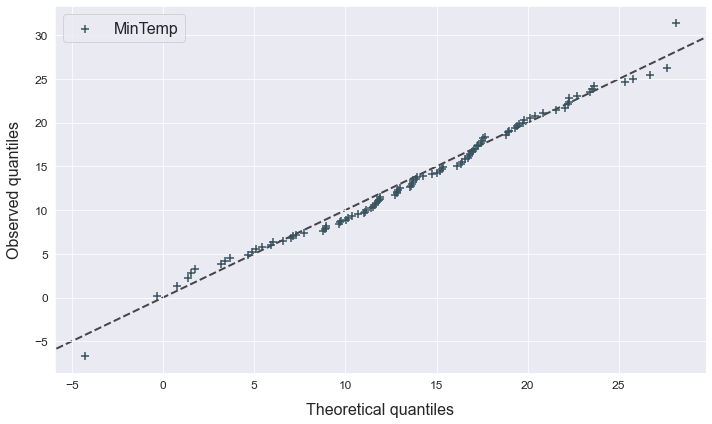

In [92]:
# Investigate a column's distribution
atom.plot_distribution("MinTemp", distribution="beta")
atom.plot_qq("MinTemp", distribution="beta")

## Change the data mid-pipeline

There are two ways to quickly transform the dataset mid-pipeline. The first way is through the property's `@setter`.
The downside for this approach is that the transformation is not stored in atom's pipeline, so the transformation is
not applied on new data. Therefore, we recommend using the second approach, through the add method.

In [93]:
# Note that we can only replace a dataframe with a new dataframe!
atom.X = atom.X.assign(AvgTemp=(atom.X["MaxTemp"] + atom.X["MinTemp"])/2)

# This will automatically update all other data attributes
assert "AvgTemp" in atom

# But it's not saved to atom's pipeline
atom.pipeline

0    Cleaner()
1    Imputer()
2    Encoder()
Name: master, dtype: object

In [94]:
# Let's drop the column to re-do the operation using apply
atom.dataset = atom.dataset.drop("AvgTemp", axis=1)

In [95]:
# Same transformation, different approach
atom.apply(lambda df: (df.MaxTemp + df.MinTemp)/2, columns="AvgTemp")

assert "AvgTemp" in atom

In [96]:
# Now the function appears in the pipeline
atom.pipeline

0                                          Cleaner()
1                                          Imputer()
2                                          Encoder()
3    FuncTransformer(func=<lambda>, columns=AvgTemp)
Name: master, dtype: object

## Use a custom metric

In [97]:
atom.verbose = 1

# Define a custom metric
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

# Use the greater_is_better, needs_proba and needs_threshold parameters if necessary
atom.run(models="LR", metric=f2_score)


Training ===================================== >>
Models: LR
Metric: f2_score


Results for Logistic Regression:         
Fit ---------------------------------------------
Train evaluation --> f2_score: 0.5691
Test evaluation --> f2_score: 0.5651
Time elapsed: 0.158s
-------------------------------------------------
Total time: 0.158s


Final results ========================= >>
Duration: 0.158s
------------------------------------------
Logistic Regression --> f2_score: 0.5651


## Customize the estimator's parameters

In [98]:
# You can use the est_params parameter to customize the estimator
# Let's run AdaBoost using LR instead of a decision tree as base estimator
atom.run("AdaB", est_params={"base_estimator": atom.lr.estimator})


Training ===================================== >>
Models: AdaB
Metric: f2_score


Results for AdaBoost:         
Fit ---------------------------------------------
Train evaluation --> f2_score: 0.5573
Test evaluation --> f2_score: 0.5465
Time elapsed: 2.300s
-------------------------------------------------
Total time: 2.300s


Final results ========================= >>
Duration: 2.300s
------------------------------------------
AdaBoost --> f2_score: 0.5465


In [99]:
atom.adab.estimator

AdaBoostClassifier(base_estimator=LogisticRegression(n_jobs=1, random_state=1),
                   random_state=1)

In [100]:
# Note that parameters specified by est_params are not optimized in the BO
atom.run(
    models="Tree",
    n_calls=3,
    n_initial_points=1,
    est_params={"max_depth": 2},
    verbose=2,
)


Training ===================================== >>
Models: Tree
Metric: f2_score


Running BO for Decision Tree...
Initial point 1 ---------------------------------
Parameters --> {'criterion': 'gini', 'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'ccp_alpha': 0}
Evaluation --> f2_score: 0.4606  Best f2_score: 0.4606
Time iteration: 0.388s   Total time: 0.404s
Iteration 2 -------------------------------------
Parameters --> {'criterion': 'gini', 'splitter': 'random', 'min_samples_split': 4, 'min_samples_leaf': 20, 'max_features': 0.5, 'ccp_alpha': 0.014}
Evaluation --> f2_score: 0.4455  Best f2_score: 0.4606
Time iteration: 0.125s   Total time: 0.565s
Iteration 3 -------------------------------------
Parameters --> {'criterion': 'gini', 'splitter': 'random', 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 0.5, 'ccp_alpha': 0.001}
Evaluation --> f2_score: 0.4460  Best f2_score: 0.4606
Time iteration: 0.125s   Total time: 0.940s


## Save & load

In [101]:
# Save the atom instance as a pickle
# Use save_data=False to save the instance without the data
atom.save("atom", save_data=False)

ATOMClassifier saved successfully!


In [102]:
# Load the instance again with ATOMLoader
# No need to store the transformed data, providing the original dataset to
# the loader automatically transforms it through all the steps in the pipeline
atom_2 = ATOMLoader("atom", data=(X,), verbose=2)

# Remember to also add the extra column!
atom_2.X = atom_2.X.assign(AvgTemp=(atom_2.X["MaxTemp"] + atom_2.X["MinTemp"])/2)

Transforming data for branch master:
Applying data cleaning...
Imputing missing values...
 --> Dropping 637 samples due to missing values in feature MinTemp.
 --> Dropping 234 samples due to missing values in feature MaxTemp.
 --> Dropping 1236 samples due to missing values in feature Rainfall.
 --> Dropping 59142 samples due to missing values in feature Evaporation.
 --> Dropping 10829 samples due to missing values in feature Sunshine.
 --> Dropping 4154 samples due to missing values in feature WindGustDir.
 --> Dropping 2199 samples due to missing values in feature WindDir9am.
 --> Dropping 208 samples due to missing values in feature WindDir3pm.
 --> Dropping 258 samples due to missing values in feature Humidity9am.
 --> Dropping 56 samples due to missing values in feature Humidity3pm.
 --> Dropping 53 samples due to missing values in feature Pressure9am.
 --> Dropping 20 samples due to missing values in feature Pressure3pm.
 --> Dropping 5361 samples due to missing values in featur

## Customize the plot aesthetics

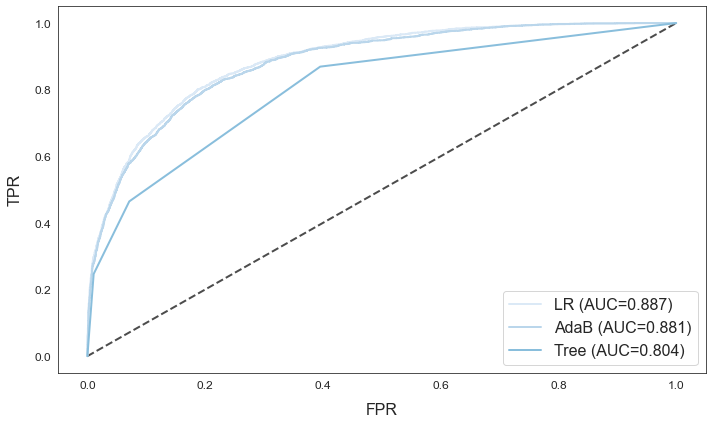

In [103]:
# Use the plotting attributes to further customize your plots!
atom_2.palette= "Blues"
atom_2.style = "white"

atom_2.plot_roc()

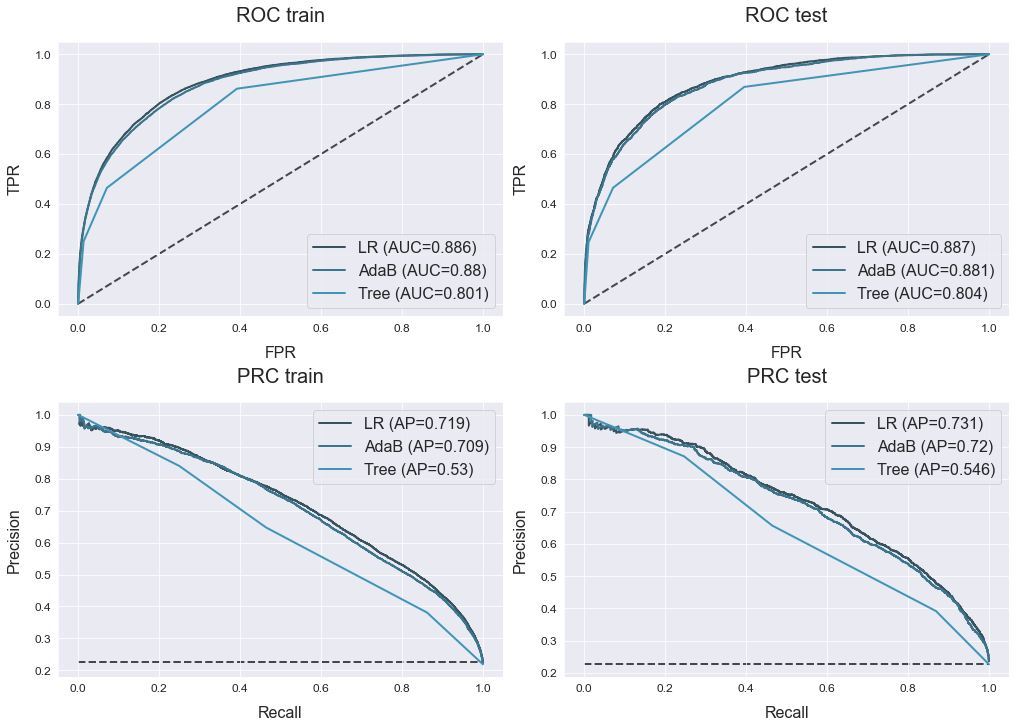

In [104]:
# Reset the aesthetics to their original values
atom_2.reset_aesthetics()

# Draw multiple plots in one figure using the canvas method
with atom.canvas(2, 2):
    atom_2.plot_roc(dataset="train", title="ROC train")
    atom_2.plot_roc(dataset="test", title="ROC test")
    atom_2.plot_prc(dataset="train", title="PRC train")
    atom_2.plot_prc(dataset="test", title="PRC test")

## Merge atom instances

In [105]:
# Create a separate instances with its own branch and model
# Note that both instances need to be initialized with the same data and
# use the same metric for model training to be able to merge
atom_3 = ATOMClassifier(X, verbose=0, warnings=False, random_state=1)
atom_3.branch.rename("lgb_branch")
atom_3.impute()
atom_3.encode("woe")
atom_3.run("LGB", metric=f2_score)

In [106]:
# Merge the instances
atom_2.merge(atom_3)

Merging atom...
 --> Merging branch lgb_branch.
 --> Merging model LGB.
 --> Merging attributes.


In [107]:
# Note that it now contains both branches and all models
atom_2

ATOMClassifier
 --> Branches:
   >>> master !
   >>> lgb_branch
 --> Models: LR, AdaB, Tree, LGB
 --> Metric: f2_score
 --> Errors: 0

In [108]:
atom_2.results


,metric_bo,time_bo,metric_train,metric_test,time_fit,time
LR,NaN,None,0.56908,0.565051,0.158s,0.158s
AdaB,NaN,None,0.55733,0.546464,2.300s,2.300s
Tree,0.460608,1.191s,0.49224,0.493427,0.095s,1.285s
LGB,NaN,None,0.65179,0.592639,1.067s,1.067s
